otimização de compra de produtos da cesta básica

### Instalação e carregamento das bibliotecas de GA em python

In [842]:
#!pip install deap
#!pip install openpyxl

In [27]:
import random
import numpy
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math
import pandas as pd
from pesquisaCompras import gera_df_cesta_basica

# matriz para o calculo final dos custos da cesta básica
matrixCustoTotal = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]

# periodo total de compras para qtd de meses
periodo_compras = 1 

# O custo máximo que posso gastar no período, neste caso mensal.
custoMaximo = 500

#### Custo do frete de cada mercado, o frete fica gratuito se o custo do mercado for maior que o valor estimado por mercado, por exemplo no carrefour fica frete gratuito acima de R$200, caso o valor seja menor que R$200 será cobrado um frete de R$20

In [12]:
custoFrete = [[200,20.0],[150,15.0],[200,30.0],[150,20.0],[150,15.0]]

#### Descontos apresentado por cada mercado, por exemplo, se o valor chegar a R$100 no Carrefour o cliente terá 5% de desconto em toda a compra

In [13]:
descontosCarrefour = [(100,5),(200,10),(300,15)]
descontosZonaSul = [(80,5),(130,10)]
descontosPaoDeAcucar = [(100,10),(150,15)]
descontosPrezunic = [(100,3),(150,5)]
descontosHortifruti = [(80,5),(160,10),(240,15)]

#### É necessário fazer o upload dos dados dos 10 produtos da cesta básica, acompanhando seus preços em 5 mercados sendo:
1 - Carrefour
2 - Zona Sul
3 - Pão de Açucar
4 - Prezunic
5 - Hortifruti

In [21]:

precos = gera_df_cesta_basica()
precos

NameError: name 'pesquisador' is not defined

In [847]:
# carregando cada array com produtos e preços
produtos = precos.iloc[:,0:3]
carrefour = precos.iloc[:,5:6]
zona_sul = precos.iloc[:,6:7]
pao_de_acucar = precos.iloc[:,7:8]
prezunic = precos.iloc[:,8:9]
hortifruti = precos.iloc[:,9:10]
lista_qtd_mensal = produtos.iloc[:,2].values
lista_qtd_mensal


array([2. , 4. , 4. , 2. , 2. , 0.5, 4. , 4. , 2. , 2. , nan])

### Declaração das funções auxiliares que devem conter as informações do problema

In [848]:
# Função que calcula o custo para cada mercado
def CustoCestaPorMercado(individual):
  custoCarrefour = 0
  custoZona_sul = 0
  custoPao_de_acucar = 0
  custoPrezunic = 0
  custoHortifruti = 0
  qtdProdCarrefour = 0
  qtdProdSonaSul = 0
  qtdProdPaoDeAcucar = 0
  qtdProdPrezunic = 0
  qtdProdHortifruti = 0
  # custo dos produtos
  #print(list(enumerate(zip(individual[0::2],individual[1::2]))))
  #for index,mercado in enumerate(individual[::2]):
  # formatando a lista para ter o mercado e a quantidade de produto na mesma iteração
  for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
    # Verificar o custo de cada produto no mercado
    mercado = cesta_mercado[0]
    qtd_prod = cesta_mercado[1]
    # custo por mercado
    if mercado == 1:
      custoCarrefour += float(carrefour.iloc[index].values*qtd_prod)
      qtdProdCarrefour += qtd_prod
    elif mercado == 2:
      custoZona_sul += float(zona_sul.iloc[index].values*qtd_prod)
      qtdProdSonaSul += qtd_prod
    elif mercado == 3:
      custoPao_de_acucar += float(pao_de_acucar.iloc[index].values*qtd_prod)
      qtdProdPaoDeAcucar += qtd_prod
    elif mercado == 4:
      custoPrezunic += float(prezunic.iloc[index].values*qtd_prod)
      qtdProdPrezunic += qtd_prod
    elif mercado == 5:
      custoHortifruti += float(hortifruti.iloc[index].values*qtd_prod)
      qtdProdHortifruti += qtd_prod
    #custoCarrefour += numpy.sum(float(carrefour.iloc[index].values*qtd_prod) if mercado == 1 else 0)
    #custoZona_sul += numpy.sum(float(zona_sul.iloc[index].values*qtd_prod) if mercado == 2 else 0)
    #custoPao_de_acucar += numpy.sum(float(pao_de_acucar.iloc[index].values*qtd_prod) if mercado == 3 else 0)
    #custoPrezunic += numpy.sum(float(prezunic.iloc[index].values*qtd_prod) if mercado == 4 else 0)
    #custoHortifruti += numpy.sum(float(hortifruti.iloc[index].values*qtd_prod) if mercado == 5 else 0)

    #qtdProdCarrefour += numpy.sum(float(qtd_prod) if mercado == 1 else 0)
    #qtdProdSonaSul += numpy.sum(float(qtd_prod) if mercado == 2 else 0)
    #qtdProdPaoDeAcucar += numpy.sum(float(qtd_prod) if mercado == 3 else 0)
    #qtdProdPrezunic += numpy.sum(float(qtd_prod) if mercado == 4 else 0)
    #qtdProdHortifruti += numpy.sum(float(qtd_prod) if mercado == 5 else 0)
  
  qtd_total_prod = qtdProdCarrefour+qtdProdSonaSul+qtdProdPaoDeAcucar+qtdProdPrezunic+qtdProdHortifruti
  '''
  # aplicando o desconto se atingir o custo para o Carrefour
  #descCarrefourReversed = list(reversed(descontosCarrefour))
  for desc in descontosCarrefour[::-1]:
    if desc[0]<=custoCarrefour:
        custoCarrefour = custoCarrefour * ((desc[1]-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Zona Sul
  for valor, desc in descontosZonaSul[::-1]:
    if valor<=custoZona_sul:
        custoZona_sul = custoZona_sul * ((desc-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Pão de Açucar
  for valor, desc in descontosPaoDeAcucar[::-1]:
    if valor<=custoPao_de_acucar:
        custoPao_de_acucar = custoPao_de_acucar * ((desc-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Prezunic
  for valor, desc in descontosPrezunic[::-1]:
    if valor<=custoPrezunic:
        custoPrezunic = custoPrezunic * ((desc-100)/100)
        break
  # aplicando o desconto se atingir o custo para o Hortifruti
  for valor, desc in descontosHortifruti[::-1]:
    if valor<=custoHortifruti:
        custoHortifruti = custoHortifruti * ((desc-100)/100)
        break
  '''
  # ajustando ao custo do frete para o Carrefour
  if custoCarrefour < custoFrete[0][0] and custoCarrefour > 0:
      custoCarrefour += custoFrete[0][1]
  # ajustando ao custo do frete para o Zona Sul
  if custoZona_sul < custoFrete[1][0] and custoZona_sul > 0:
      custoZona_sul += custoFrete[1][1]    
  # ajustando ao custo do frete para o Pão de Açucar
  if custoPao_de_acucar < custoFrete[2][0] and custoPao_de_acucar > 0:
      custoPao_de_acucar += custoFrete[2][1] 
  # ajustando ao custo do frete para o Prezunic
  if custoPrezunic < custoFrete[3][0] and custoPrezunic >0:
      custoPrezunic += custoFrete[3][1] 
  # ajustando ao custo do frete para o Hortifruti
  if custoHortifruti < custoFrete[4][0] and custoHortifruti > 0:
      custoHortifruti += custoFrete[4][1] 
  
  return [custoCarrefour,custoZona_sul,custoPao_de_acucar,custoPrezunic,custoHortifruti],qtd_total_prod

In [849]:
# Função Objetivo -> Repare que o único parametro que a função deve receber é um individuo
def CustoCesta(individual):
  custoTotal = 0
  # recupera os custos por mercado
  listaCustos, qtd_tot_prod = CustoCestaPorMercado(individual)
  # custo dos produtos
  custoTotal = numpy.sum(listaCustos)
  #qtd_tot_prod = CustoCestaPorMercado(individual)[1]

  return custoTotal,qtd_tot_prod

In [850]:
## Funcao para validar se é factivel
def eh_factivel(individual):
    # recupera o custo total, para comparar com o meu limite de compras do período
    custoTotal = CustoCesta(individual)[0]
    # lista da quantidade de produto
    list_qtd_prod = individual[1::2]
    # lista do máximo de quantidade de produto
    #qtd_prod_periodo = periodo_compras*produtos.iloc[:,2].values
    #if custoTotal > custoMaximo:
    #    return True
    
    # nenhum produto pode ter qtd igual a zero
    ind_eh_factivel = True
    for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
        # Verificar o custo de cada produto no mercado
        mercado = cesta_mercado[0]
        qtd_prod = cesta_mercado[1]
        # nem mercado e nem a qtd de produtos podem ser zero e também não pode ser inferior a qtd mínima do produto no periodo
        if mercado == 0 or qtd_prod == 0 or (periodo_compras*lista_qtd_mensal[index]) > qtd_prod:
            ind_eh_factivel = False
            break
    #if ind_eh_factivel and custoTotal <= custoMaximo and custoTotal > 0:
    if ind_eh_factivel and custoTotal > 0:
        return True
    return False

In [851]:
## Funcao de Penalização
def penalidade(individual):
    # recupera o custo total, para comparar com o meu limite de compras do período
    custoTotal = CustoCesta(individual)[0]
    qtd_prod = CustoCesta(individual)[1]
    custo_penalidade = 0
    #if custoTotal > custoMaximo:
    custo_penalidade = (custoTotal+custoMaximo)**2
    #custo_penalidade = custoMaximo-(custoTotal+custoMaximo)**2
    '''
    for index,cesta_mercado in enumerate(zip(individual[0::2],individual[1::2])):
        # Verificar o custo de cada produto no mercado
        mercado = cesta_mercado[0]
        qtd_prod = cesta_mercado[1]
        if mercado == 0 or qtd_prod == 0:
            custo_penalidade = (custoTotal+custoMaximo)**10
    
    return custo_penalidade, 0.0
    '''
    if eh_factivel(individual):
        return CustoCesta(individual)
    else:
        return custo_penalidade, qtd_prod-100000

### Declaração dos pacotes referentes a biblioteca do GA: 
#### Nomenclatura referente a biblioteca e deve-se alterar somente os pesos das funções que deverão ser, ou maximizada ou minimizada
#### Pode-se alterar também o tipo da variavel do Individuo. Mas que, geralmente, é uma lista de numeros inteiros

In [852]:
creator.create("FitnessMult", base.Fitness, weights=(-1.0,1.0))
#creator.create("FitnessMult", base.Fitness, weights=(1.0,1.0))
creator.create("Individual", list, fitness=creator.FitnessMult)

c:\ProgramsNokia\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMult' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\ProgramsNokia\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [853]:
#mercados = numpy.random.choice(range(1,6), size=10,  replace=True)
#qtd_prod = numpy.random.choice(range(1,11), size=10,  replace=True)
mercado_min = 1
mercado_max = 5
qtd_prod_min = 1
qtd_prod_max = 10

In [854]:
toolbox = base.Toolbox()
# Definir o gerador de numeros inteiros aleatórios de (1 a 5) para os mercados.
# Definir o gerador de numeros inteiros aleatórios de (1 a 10) para a qtd de produtos.
#toolbox.register("random_int_mercado", numpy.random.choice, range(1,6), size=10,  replace=True)
#toolbox.register("random_int_qtd_prod", numpy.random.choice, range(1,11), size=10,  replace=True)
toolbox.register("random_int_mercado", random.randint, mercado_min, mercado_max)
toolbox.register("random_int_qtd_prod", random.randint, qtd_prod_min, qtd_prod_max)
# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
#toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.random_int)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.random_int_mercado,toolbox.random_int_qtd_prod), n=10)
# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registro do nome da função objetivo
toolbox.register("evaluate", penalidade)

#################################### OPERADORES ####################################
# Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
#toolbox.register("mate", tools.cxTwoPoints) #, indpb=0.8)
toolbox.register("mate", tools.cxUniform, indpb=0.8)
# Registro da função de penalidade caso o individuo não obedeça as restrições
#toolbox.register("evaluate", tools.DeltaPenalty(restricao, penalidade, CustoCesta))
# Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
# toolbox.register("mutate", MutationFunction, indpb=0.1)
# Registro de qual o tipo do método de seleção que será utilizado
#toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("select", tools.selNSGA2)

In [855]:
#toolbox.individual() # [mercado, qtd_prod, mercado, qtd_prod,....]
#for index, cesta_mercado in enumerate(zip(toolbox.individual()[0::2],toolbox.individual()[1::2])):
#    print (index, cesta_mercado[0], cesta_mercado[1])
#i1 = toolbox.individual()
#print(i1.fitness)


## Chamada efetiva do GA para resolução

In [856]:
pop = toolbox.population(n=100)                           # inicialização da pop
hof = tools.HallOfFame(1)                                 # melhor indivíduo
#stats_func1 = tools.Statistics(key=lambda ind: ind.fitness.values[0::2])
#stats_func2 = tools.Statistics(key=lambda ind: ind.fitness.values[1::2])
#stats = tools.MultiStatistics(func1=stats_func1, func2=stats_func2)
#stats.register("avg", numpy.mean)
#stats.register("std", numpy.std)
#stats.register("min", numpy.min)
#stats.register("max", numpy.max)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda x: tuple(map(lambda y: sum(y) / len(y), zip(*x))))
stats.register("min", lambda x: tuple(map(min, zip(*x))))
stats.register("max", lambda x: tuple(map(max, zip(*x))))

In [857]:
#pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=100, stats=stats, halloffame=hof, verbose=True) #aumentei mut = 0.7
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.7, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

C:\Users\vifaria\AppData\Local\Temp\ipykernel_18124\3884680878.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custoCarrefour += float(carrefour.iloc[index].values*qtd_prod)
C:\Users\vifaria\AppData\Local\Temp\ipykernel_18124\3884680878.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custoPao_de_acucar += float(pao_de_acucar.iloc[index].values*qtd_prod)
C:\Users\vifaria\AppData\Local\Temp\ipykernel_18124\3884680878.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated Nu

gen	nevals	avg                           	min               	max                      
0  	100   	(2993930.821158001, -85944.52)	(1064.4, -99970.0)	(7485750.720100001, 72.0)
1  	86    	(1337944.0242639994, -47939.64)	(945.3800000000001, -99965.0)	(5120806.9264, 72.0)     
2  	90    	(1367.678, 65.48)              	(938.6600000000001, 52.0)    	(2009.0900000000001, 72.0)
3  	90    	(1215.3651999999995, 65.22)    	(923.36, 52.0)               	(1809.96, 76.0)           
4  	87    	(1145.1001999999999, 64.98)    	(908.71, 52.0)               	(1794.09, 81.0)           
5  	88    	(1142.0021999999997, 67.38)    	(876.5999999999999, 50.0)    	(1777.15, 81.0)           
6  	93    	(1191.1950000000002, 70.1)     	(803.95, 53.0)               	(1787.2, 82.0)            
7  	92    	(1152.2624, 70.9)              	(782.95, 48.0)               	(1787.2, 85.0)            
8  	88    	(1113.4888, 70.62)             	(773.16, 47.0)               	(1558.1299999999999, 85.0)
9  	89    	(1086.5824000000

## Resultados

In [858]:
# Melhor solução
print("Melhor Indivíduo:")
print(hof[0])

# Verificação da função de restrição
print(eh_factivel(hof[0]))
print(penalidade(hof[0]))


# Melhor resultado da função objetivo
print("Melhor Resultado da Função Objetivo:")
CustoCesta(hof[0])
#CustoCesta([3,1,3,1,3,1,3,1,3,1,3,1,3,1,3,1,3,1,3,1])

Melhor Indivíduo:
[1, 8, 3, 6, 1, 6, 3, 7, 1, 4, 2, 1, 2, 5, 3, 4, 1, 9, 1, 2]
True
(660.48, 52)
Melhor Resultado da Função Objetivo:


C:\Users\vifaria\AppData\Local\Temp\ipykernel_18124\3884680878.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custoCarrefour += float(carrefour.iloc[index].values*qtd_prod)
C:\Users\vifaria\AppData\Local\Temp\ipykernel_18124\3884680878.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custoPao_de_acucar += float(pao_de_acucar.iloc[index].values*qtd_prod)
C:\Users\vifaria\AppData\Local\Temp\ipykernel_18124\3884680878.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated Nu

(660.48, 52)

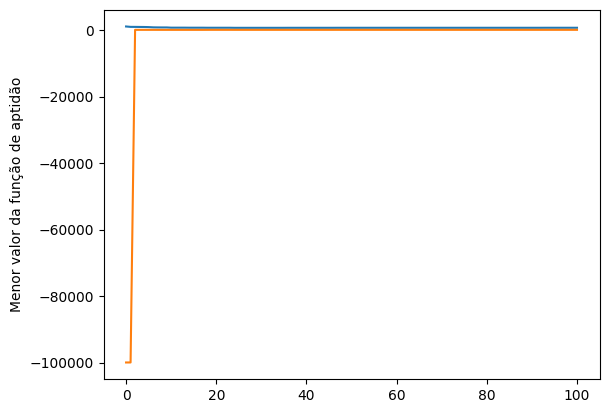

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100] [(1064.4, -99970.0), (945.3800000000001, -99965.0), (938.6600000000001, 52.0), (923.36, 52.0), (908.71, 52.0), (876.5999999999999, 50.0), (803.95, 53.0), (782.95, 48.0), (773.16, 47.0), (772.74, 47.0), (706.45, 46.0), (706.45, 46.0), (706.45, 46.0), (706.45, 46.0), (694.15, 46.0), (694.15, 46.0), (693.6199999999999, 46.0), (693.6199999999999, 46.0), (679.47, 52.0), (679.47, 55.0), (679.47, 55.0), (679.47, 55.0), (679.47, 55.0), (679.47, 55.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.0), (660.48, 52.

In [859]:
import matplotlib.pyplot as plt
gen, minVal = log.select("gen", "min")
plt.plot(gen, minVal)
plt.ylabel('Menor valor da função de aptidão')
plt.show()
print(gen, minVal)